# Copacabana Runs on Buzzard v2.0

This notebook has some of my runs on the Buzzard v2.0 y3 catalog.

## Import Packages

In [6]:
import sys
sys.path.append('/home/s1/jesteves/git/ccopa/python')

from main import copacabana
from make_input_files.make_photoz_pz import generate_photoz_models
from make_input_files.make_input_datasets import read_hdf5_file_to_dict

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

#### Starting Copa

In [8]:
root = '/home/s1/jesteves/git/buzzardAnalysis/mainAnalysis/'
cfg  = root+'config_buzzard_rm_v2_bcp.yaml'
copa = copacabana(cfg,dataset='buzzard_v2')

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt5_lw20_copa_00520.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt5_lw20_copa_00539.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt5_lw20_copa_00540.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles


## Prepare Files

### Pre-process RedMaPPer Cluster Data

In [4]:
import healpy as hp

def radec_pix(ra,dec,nside=1024):
    return np.array(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra),nest=True),dtype=np.int64)

In [37]:
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24
rad2deg= 180/np.pi
h=0.7

#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

def convertM200toR200(M200,z,nc=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = rhoc(z)
    R200 = ( M200/(nc*4*np.pi*rho/3) )**(1/3.)
    return R200/h

In [38]:
import os
from astropy.table import Table
from astropy.io.fits import getdata

outdata = "/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/halos/buzzard-1.9.8_3y3a_run_halos_lambda_lgt5_lw20.fits"
rm_file = "/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/halos/buzzard-1.9.8_3y3a_run_halos_lambda_chisq.fit"
columns = ['haloid','RA','DEC','redshift','M200','R200', 'hpx2','MEM_MATCH_ID','z_true','LAMBDA_CHISQ']
#columns = ['CID','RA','DEC','redshift','M200_true','R200_true','DA','magLim','MEM_MATCH_ID','z_true']

if not os.path.isfile(outdata):
    cat = Table(getdata(rm_file))
    cut = (cat['LAMBDA_CHISQ']>=5.)&(cat['Z_LAMBDA']>=0.2)&(cat['Z_LAMBDA']<=0.65)
    cat = cat[cut]

    print('All Columns')
    print(cat.colnames)
    
    cat['hpx2'] = radec_pix(cat['RA'],cat['DEC'],nside=8)
    cat['R200'] = convertM200toR200(cat['M200']*h,cat['Z'])
    
    ## healpix cut
    cat = cat[(cat['hpx2']>=500)&(cat['hpx2']<=550)]
    
    cat.rename_column('HALOID','haloid')
    cat.rename_column('Z','z_true')
    cat.rename_column('Z_LAMBDA','redshift')

    cat[columns].write(outdata,format='fits',overwrite=True)
else:
    print('Cluster File already exists')

Cluster File already exists


In [39]:
cat[columns]

haloid,RA,DEC,redshift,M200,R200,hpx2,MEM_MATCH_ID,z_true,LAMBDA_CHISQ
int32,float64,float64,float32,float32,float64,int64,int32,float32,float32
28071743,88.80884013396891,-50.262235550542016,0.50945777,1753000000000000.0,2.6552309486928563,532,1,0.5024944,253.22153
23678793,23.29840546123235,-48.44989561089565,0.609486,1679000000000000.0,2.5199106802889517,547,2,0.6013021,120.61004
12502745,76.89850088848532,-39.9638837198587,0.24004968,1258000000000000.0,2.61153630054688,534,9,0.24627402,44.670776
12502877,70.19421151641316,-50.4050271656225,0.21551533,1220000000000000.0,2.6129428177388223,531,11,0.21502268,54.12886
15560171,70.95749424069122,-30.887314476646424,0.30951235,1161000000000000.0,2.4912486171079102,541,15,0.30410558,26.074965
23560350,28.77835944811287,-43.23612318226782,0.41497853,1117000000000000.0,2.3584016269532575,550,16,0.41857025,112.90628
12803495,69.2808555365405,-40.91823284209241,0.27476603,1088000000000000.0,2.478741431390142,534,17,0.2571574,85.59988
22733962,56.256101697895055,-46.10989126065371,0.48038262,1022000000000000.0,2.2276852781956826,536,21,0.49122947,70.92459
10103953,61.961652060709426,-57.80593755406866,0.21725355,990900000000000.0,2.4327686905734547,519,28,0.22121416,32.024406


### Rename files

In [40]:
import os
import glob
import numpy as np
 
def get_healpix_list(file_list):
    healpix_list = []
    for infile in file_list:
        hpx = int(infile.split('_')[-1].split('.')[0])
        healpix_list.append(hpx)
    healpix_list = np.sort(np.array(healpix_list))
    return healpix_list
 
def rename_files(base_name,file_list):
    for infile in file_list:
        hpx = int(infile.split('_')[-1].split('.')[0])
        new_file = base_name.format(hpx)
        print((infile,new_file))
        os.rename(infile,new_file)
        
outdir = '/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/tiles/'
files  = glob.glob(outdir+'buzzard_y3_v2.0.0_redmapper_heidi_lgt5_lw20_copper_hpx8_*.hdf')
healpix_list = get_healpix_list(files)

print(healpix_list)

base_name = '/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/tiles/buzzard_y3_v2.0.0_redmapper_heidi_lgt5_lw20_copper_hpx8_{:05d}.hdf5'
rename_files(base_name,files)

[]


# Run Pre-Processing

Given the hdf5 input files, the function *make_input_file()* returns a master file with all the input file, cluster and members

In [9]:
copa.make_input_file()

Running pre_processing_healpix() instead 

cluster columns
{'R200_true': 'R200', 'DEC': 'DEC', 'RA': 'RA', 'redshift': 'redshift', 'tile': 'hpx2', 'M200_true': 'M200', 'HALOID': 'haloid'}
tile : 520
counts: 0
Error: the tile 520 is empty

tile : 539
counts: 2497
Loading Data
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/tiles/buzzard_y3_v2.0.0_redmapper_heidi_lgt5_lw20_copper_hpx8_00539.hdf5
ngals : 4.39e+06
Writing Master File
Partial time: 1056.94 s 

tile : 540
counts: 2730
Loading Data
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/tiles/buzzard_y3_v2.0.0_redmapper_heidi_lgt5_lw20_copper_hpx8_00540.hdf5
ngals : 4.50e+06
Writing Master File
Partial time: 1155.11 s 



In [61]:
!h5ls /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/tiles/buzzard_y3_v2.0.0_redmapper_heidi_lgt20_copper_hpx8_00000.hdf5

cluster                  Group
members                  Group


In [62]:
!h5ls /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5/clusters/main

CID                      Dataset {424}
DA                       Dataset {424}
DEC                      Dataset {424}
M200_true                Dataset {424}
R200_true                Dataset {424}
RA                       Dataset {424}
magLim                   Dataset {424, 3}
redshift                 Dataset {424}


The members catalog has all the input galaxies with the input columns
``` GID,CID,redshift,RA,DEC,R,z,zerr,zoffset,zwindow,mag,magerr,dmag,pz0,z_true,TRUE, BKG```

In [63]:
!h5ls /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_00033.hdf5/members/main

Bkg                      Dataset {10230616}
CID                      Dataset {10230616}
DEC                      Dataset {10230616}
GID                      Dataset {10230616}
HALOID                   Dataset {10230616}
Mr                       Dataset {10230616}
R                        Dataset {10230616}
RA                       Dataset {10230616}
True                     Dataset {10230616}
dmag                     Dataset {10230616}
mag                      Dataset {10230616, 4}
magerr                   Dataset {10230616, 4}
mid                      Dataset {10230616}
pz0                      Dataset {10230616}
redshift                 Dataset {10230616}
z                        Dataset {10230616}
z_true                   Dataset {10230616}
zerr                     Dataset {10230616}
zoffset                  Dataset {10230616}


## Create Indices Selection

We want to test different magnitude selections.

### 0.2 $L_{\star}$ Buzzard 

The charcteristic magnitude used in Buzzard is not directly provided. They have in DeRose+19 the luminosity functional form. 
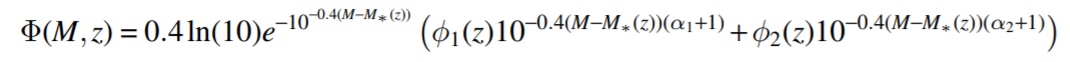

William Black fitted using 5 parameters, his fitted values for m*(z) is in the cell bellow. It's important to mention that 0.2 / 0.4 $L_{\star}$ corresponds to m*(z)+1.75/1.00.

In [9]:
Z1 = [ 2.85703803, 23.35451485]
Z2 = [ -0.13290108,   1.11453393,  -3.74351207,   6.96351527, -10.04310863,  12.60755443,  -7.85820367,   0.92175766]
def char_luminosity(z):
    return np.poly1d(Z1)(np.log(z)) + np.poly1d(Z2)(z)

### Applying Mag Selection for the whole sample

In [65]:
def apply_02Lstar_cut(fname):
    print('loading data: %s'%fname)
    out = read_hdf5_file_to_dict(fname,cols=['redshift','mag'],path='members/main/')
    mag = out['mag'][:,2]  ## i-band
    zcls= out['redshift'][:]
    
    #print('applying mask')
    cut = mag <= char_luminosity(zcls)+1.75
    indices = np.where(cut)[0]
    
    print('writing indices selection: %s \n'%('members/indices/02Lstar'))
    write_indices_out(indices,fname,overwrite=False,col='02Lstar')

In [66]:
def apply_dmag_cut(fname):
    print('loading data: %s'%fname)
    out = read_hdf5_file_to_dict(fname,cols=['redshift','mag', 'dmag'],path='members/main/')
    mag = out['dmag'][:]

    #print('applying mask')
    cut = mag <= 0.
    indices = np.where(cut)[0]
    
    print('writing indices selection: %s \n'%('members/indices/dmag_0'))
    write_indices_out(indices,fname,overwrite=False,col='dmag_0')

In [67]:
def write_indices_out(indices,fname,col='02Lstar',overwrite=False):
    fmaster = h5py.File(fname, 'a')
    if 'indices' not in fmaster['members/'].keys():
        fmaster.create_group('members/indices')

    group = fmaster['members/indices']
    
    try:
        group.create_dataset(col,data=indices)
    except:
        if overwrite:
            del group[col]
            group.create_dataset(col,data=indices)
        else:
            print('Error: indices already exists')
    
    fmaster.close()

In [68]:
for fname in copa.master_fname_tile_list:
    apply_02Lstar_cut(fname)
    apply_dmag_cut(fname)

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00261.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00261.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00263.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00263.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00269.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00269.hdf5
writi

writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00298.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00298.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00299.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00299.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00300.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output

writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00530.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00531.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00531.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00532.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00532.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output

writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00554.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00554.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00555.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00555.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00556.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output

writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00616.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00618.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00618.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00709.hdf5
writing indices selection: members/indices/02Lstar 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00709.hdf5
writing indices selection: members/indices/dmag_0 

loading data: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output

writing indices selection: members/indices/dmag_0 



In [69]:
## Example

In [6]:
fname = copa.master_fname_tile_list[1]

In [7]:
out = read_hdf5_file_to_dict(fname,cols=['redshift','mag','dmag'],path='members/main/')
mag = out['mag'][:,2]  ## i-band
dmag = out['dmag'][:]
zcls= out['redshift']

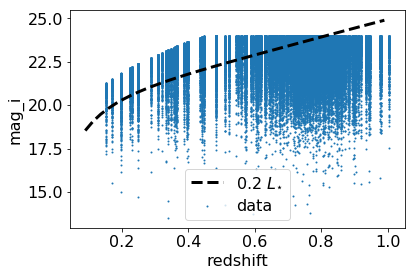

In [10]:
zvec = np.linspace(0.09,0.99,40)
plt.plot(zvec,char_luminosity(zvec)+1.75,'k--',lw=3,label=r'0.2 $L_{\star}$')

plt.scatter(zcls[::50],mag[::50],s=1,label='data')
#plt.scatter(zcls[indices][::50],mag[indices][::50],s=1,label='data')
plt.xlabel('redshift')
plt.ylabel('mag_i')
plt.legend()

In [11]:
cut = mag <= char_luminosity(zcls)+1.75
indices = np.where(cut)[0]

In [74]:
# out = read_hdf5_file_to_dict(fname,cols=['z_true','z','zerr','mag'],path='members/main/')

In [75]:
# mask = out['mag'][:,2]>23
# zdnf = out['z'][:]

In [76]:
# out = read_hdf5_file_to_dict(fname,cols=None,path='members/indices/')

## Create Photo-z Catalogs

### Gaussian Photo-z

In [77]:
generate_photoz_models('gaussian',copa.master_fname_tile_list,0.01,nCores=60)
generate_photoz_models('gaussian',copa.master_fname_tile_list,0.03,nCores=60)
generate_photoz_models('gaussian',copa.master_fname_tile_list,0.05,nCores=60)

Generating photoz catalog: gauss001

Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00261.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 0.67 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00263.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 0.96 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00269.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 1.25 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00271.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 1.72 min


Load Infile
infile:

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 15.98 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00352.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 16.25 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00518.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 16.67 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00519.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 16.96 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00521.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 31.57 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00553.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 32.13 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00554.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 32.70 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00555.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 33.13 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00556.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 49.00 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00720.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 49.46 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00721.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 49.94 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00722.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 50.42 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00723.hdf5
Error: zmodel file is None
Error: model file is None

Writing outfile
partial time: 10.17 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00296.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 10.42 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00297.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 10.97 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00298.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 11.45 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00299.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 11.74 min


Load Infil

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 24.85 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00540.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 25.29 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00541.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 25.74 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00542.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 26.11 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00543.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 42.52 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00575.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 42.99 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00610.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 43.37 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00616.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 43.75 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00618.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 4.55 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00277.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 5.20 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00278.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 5.76 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00279.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 6.33 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00280.hdf5
Error: zmodel file is None
Error: model file is None
Com

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 19.86 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00527.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 20.25 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00528.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 20.53 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00529.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 20.91 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00530.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 36.74 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00562.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 37.23 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00563.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 37.69 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00564.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 38.13 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00565.hdf5
Error: zmodel file is None
Error: model file is None

Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 53.34 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00730.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 53.80 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00731.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 54.10 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00740.hdf5
Error: zmodel file is None
Error: model file is None
Computing pz0
Writing outfile
partial time: 54.44 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00741.hdf5
Error: zmodel file is None
Error: model file is None

In [78]:
outfile1=root+'aux_files/modelDNF_correction_mag_buzzard.txt'
outfile2=root+'aux_files/modelDNF_correction_z_buzzard.txt'

generate_photoz_models('bias',copa.master_fname_tile_list,0.03,
                       zwindow_file=outfile2,zerror_file=outfile1,
                       group_name='dnf_model',nCores=60)

Generating photoz catalog: dnf_model

Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00261.hdf5
Computing pz0
Writing outfile
partial time: 0.75 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00263.hdf5
Computing pz0
Writing outfile
partial time: 1.09 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00269.hdf5
Computing pz0
Writing outfile
partial time: 1.39 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00271.hdf5
Computing pz0
Writing outfile
partial time: 1.88 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00272.hdf5
Computing pz0
Writing outfile
partial time: 2.43 min


Load Infile
infile: /data/des61.a/data/johnny/B

Computing pz0
Writing outfile
partial time: 20.86 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00528.hdf5
Computing pz0
Writing outfile
partial time: 21.11 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00529.hdf5
Computing pz0
Writing outfile
partial time: 21.53 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00530.hdf5
Computing pz0
Writing outfile
partial time: 21.98 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00531.hdf5
Computing pz0
Writing outfile
partial time: 22.45 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00532.hdf5
Computing pz0
Writing outfile
partial time: 22.87 min


Load Infile
infile: /dat

Computing pz0
Writing outfile
partial time: 43.78 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00573.hdf5
Computing pz0
Writing outfile
partial time: 44.19 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00574.hdf5
Computing pz0
Writing outfile
partial time: 44.86 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00575.hdf5
Computing pz0
Writing outfile
partial time: 45.38 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00610.hdf5
Computing pz0
Writing outfile
partial time: 45.77 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00616.hdf5
Computing pz0
Writing outfile
partial time: 46.17 min


Load Infile
infile: /dat

In [79]:
outfile1=None#root+'aux_files/modelDNF_correction_mag_buzzard.txt'
outfile2=root+'aux_files/modelDNF_correction_z_buzzard.txt'

generate_photoz_models('bias',copa.master_fname_tile_list,0.03,
                       zwindow_file=outfile2,zerror_file=outfile1,
                       group_name='dnf',nCores=60)

Generating photoz catalog: dnf

Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00261.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 0.75 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00263.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 1.05 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00269.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 1.34 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00271.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 1.81 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00272.hdf5
Erro

Error: model file is None
Computing pz0
Writing outfile
partial time: 18.59 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00523.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 19.13 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00524.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 19.71 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00525.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 20.13 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00526.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 20.60 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/out

Writing outfile
partial time: 38.17 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00562.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 38.75 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00563.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 39.22 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00564.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 39.73 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00565.hdf5
Error: model file is None
Computing pz0
Writing outfile
partial time: 40.26 min


Load Infile
infile: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_0

In [10]:
!h5ls /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3_rm/output/tiles/buzzard_v2.0.0_rm_lgt20_copa_00527.hdf5/members/bma

CID                      Dataset {179891}
best_chisq               Dataset {179891}
best_model               Dataset {179891}
best_zmet                Dataset {179891}
distmod                  Dataset {179891}
gi_o                     Dataset {179891}
gi_o_err                 Dataset {179891}
gr_o                     Dataset {179891}
gr_o_err                 Dataset {179891}
iabs                     Dataset {179891}
index                    Dataset {179891}
iobs                     Dataset {179891}
kii                      Dataset {179891}
kii_err                  Dataset {179891}
kri                      Dataset {179891}
kri_err                  Dataset {179891}
mass                     Dataset {179891}
mass_err                 Dataset {179891}
mass_weight_age          Dataset {179891}
mass_weight_age_err      Dataset {179891}
mcMass                   Dataset {179891}
mid                      Dataset {179891}
mid_cut                  Dataset {179891}
rabs                     Dataset {

Beyond the main catalog, we have the different photo-z catalogs used during the code validation.

## Run BMA

In [4]:
##### Atention: this cell takes more than 6 hours to run. It only needs to be run one time.

copa.run_bma_healpix(nCores=65,overwrite=True)



-------------------------
Starting BMA
divided in nchunks: 610
each tile divided in 5 chunks 

Healpixel: 00000
making bma cutout
sample size: 168407 

Healpixel: 00256
making bma cutout
sample size: 267293 

Healpixel: 00257
making bma cutout
sample size: 324302 

Healpixel: 00260
making bma cutout
sample size: 237643 

Healpixel: 00261
making bma cutout
sample size: 358040 

Healpixel: 00263
making bma cutout
sample size: 77660 

Healpixel: 00269
making bma cutout
sample size: 60935 

Healpixel: 00271
making bma cutout
sample size: 202598 

Healpixel: 00272
making bma cutout
sample size: 263411 

Healpixel: 00273
making bma cutout
sample size: 214170 

Healpixel: 00274
making bma cutout
sample size: 129887 

Healpixel: 00275
making bma cutout
sample size: 286364 

Healpixel: 00276
making bma cutout
sample size: 302094 

Healpixel: 00277
making bma cutout
sample size: 335798 

Healpixel: 00278
making bma cutout
sample size: 269425 

Healpixel: 00279
making bma cutout
sample size: 30

starting parallel process
runing on the following batches: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 

Process PoolWorker-52:
Process PoolWorker-38:
Process PoolWorker-31:
Process PoolWorker-26:
Process PoolWorker-39:
Process PoolWorker-36:
Process PoolWorker-34:
Process PoolWorker-29:
Process PoolWorker-32:
Process PoolWorker-27:
Process PoolWorker-30:
Process PoolWorker-43:
Process PoolWorker-16:
Process PoolWorker-58:
Process PoolWorker-3:
Traceback (most recent call last):
Process PoolWorker-37:
Process PoolWorker-55:
Traceback (most recent call last):
Process PoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-20:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multipr

  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    task = get()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anacon

Traceback (most recent call last):
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(

Process PoolWorker-28:
Process PoolWorker-40:
Process PoolWorker-22:
Process PoolWorker-47:
Process PoolWorker-17:
Process PoolWorker-12:
Process PoolWorker-14:
Process PoolWorker-42:
    self._target(*self._args, **self._kwargs)
Process PoolWorker-60:
Process PoolWorker-48:
Process PoolWorker-62:


IndexError: string index out of range

Process PoolWorker-18:
Process PoolWorker-59:
Traceback (most recent call last):
Process PoolWorker-46:
Process PoolWorker-50:
Process PoolWorker-23:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
Process PoolWorker-64:
Process PoolWorker-24:
Process PoolWorker-7:
Process PoolWorker-61:
Process PoolWorker-8:
Process PoolWorker-41:
Process PoolWorker-13:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-6:
Process PoolWorker-45:
Process PoolWorker-44:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call 

    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self.run()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run(

  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/cvmfs/des.openscie

    task = get()
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
    task = get()
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marcelle/joblib-0.9.0b4/joblib/pool.py", line 358, in get
  File "/data/des41.a/data/marc

In [4]:
!h5ls /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00032.hdf5/members/bma

CID                      Dataset {165430}
best_chisq               Dataset {165430}
best_model               Dataset {165430}
best_zmet                Dataset {165430}
distmod                  Dataset {165430}
gi_o                     Dataset {165430}
gi_o_err                 Dataset {165430}
gr_o                     Dataset {165430}
gr_o_err                 Dataset {165430}
iabs                     Dataset {165430}
index                    Dataset {165430}
iobs                     Dataset {165430}
kii                      Dataset {165430}
kii_err                  Dataset {165430}
kri                      Dataset {165430}
kri_err                  Dataset {165430}
mass                     Dataset {165430}
mass_err                 Dataset {165430}
mass_weight_age          Dataset {165430}
mass_weight_age_err      Dataset {165430}
mcMass                   Dataset {165430}
mid                      Dataset {165430}
mid_cut                  Dataset {165430}
rabs                     Dataset {

The output are the quantities provided by the BMA Stellar Mass Estimator, https://github.com/apalmese/BMAStellarMasses. The column ``index`` is the indice from the main catalog.